# Diabetic Retinopathy Project

## <font color='red'>Table of Contents</font>

[ 1. Importing Libraries](#section1)<br>
[ 2. Visualizing Datasets](#section2)<br>
[ 3. Image Processing](#section3)<br>
[ 4. TSNE Visualization](#section4)<br>
[ 5. Data Augmentation](#section5)<br>
[ 6. Train-Validation Split](#section6)<br>
[ 7. Resize and Save](#section7)<br>
[ 8. Image Preprocessing and Save](#section8)<br>
[ 9. Custom Image Data Generator](#section9)<br>
[10. Model Training](#section10)<br>
[11. Evaluate Model on Test Data](#section11)<br>


#  <a id = 'section1'> <font color='grey'>  1. Importing Libraries </font> </a>

In [3]:
# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
from multiprocessing.pool import ThreadPool
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os

# Vis Libs..
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# Image Libs.
from PIL import Image
import cv2

# sklearn libs..
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

# DL Libs..
import tensorflow 
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from tensorflow.keras import optimizers,Model
from tensorflow.keras.layers import Input, MaxPooling2D,Dropout,Dense,Activation, Flatten, Conv2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy,mean_squared_error
from tensorflow.keras import backend as K

from google.colab import drive

drive.mount('/content/gdrive')

MessageError: ignored

#  <a id = 'section2'> <font color='grey'>  2. Visualizing Datasets </font> </a>

In [ ]:
# This function reads data from the respective train and test directories

def load_data():
    train = pd.read_csv('/content/gdrive/MyDrive/Project/datasets/trainLabels.csv')
    #test = pd.read_csv('C:/Users/Sandeep Saurav/ML Project - DR/datasets/testLabels.csv')
    
    train_dir = os.path.join('/content/gdrive/MyDrive/Project/datasets/train/')
    #test_dir = os.path.join('C:/Users/Sandeep Saurav/ML Project - DR/datasets/test/')
    
    train['file_path'] = train['ImageID'].map(lambda x: os.path.join(train_dir,'{}.jpeg'.format(x)))
    #test['file_path'] = test['ImageID'].map(lambda x: os.path.join(test_dir,'{}.jpeg'.format(x)))
    
    train['file_name'] = train["ImageID"].apply(lambda x: x + ".jpeg")
    #test['file_name'] = test["ImageID"].apply(lambda x: x + ".jpeg")
    
    train['Diagnosis'] = train['Diagnosis'].astype(str)
    
    return train

In [ ]:
df_train = load_data()
print(df_train.shape)
df_train.head(6)

(5000, 4)


,ImageID,Diagnosis,file_path,file_name
0,10_left,0,C:/Users/Sandeep Saurav/ML Project - DR/datase...,10_left.jpeg
1,10_right,0,C:/Users/Sandeep Saurav/ML Project - DR/datase...,10_right.jpeg
2,13_left,0,C:/Users/Sandeep Saurav/ML Project - DR/datase...,13_left.jpeg
3,13_right,0,C:/Users/Sandeep Saurav/ML Project - DR/datase...,13_right.jpeg
4,15_left,1,C:/Users/Sandeep Saurav/ML Project - DR/datase...,15_left.jpeg
5,15_right,2,C:/Users/Sandeep Saurav/ML Project - DR/datase...,15_right.jpeg


### <font color='orange'> 2.1 Class Distribution </font>

In [ ]:
# This Function Plots a Bar plot of output Classes Distribution

def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('Diagnosis').agg('size').reset_index())
    df_group.columns = ['Diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot
    sns.barplot(x = 'Diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution')
    plt.show() 

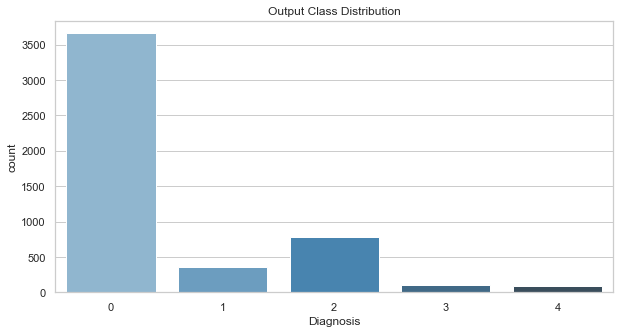

In [ ]:
plot_classes(df_train)

##### NOTE : As we can see, there is class imbalance in the class distribution. We can account for this while training the models using data augmentation / class balancing methods.

### <font color='orange'> 2.2 Visualize Images </font>

In [ ]:
# Defining a global variable to be used as Image size..
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [ ]:
# This Function converts a color image to gray scale image

def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    return img
  
    
# This Function shows the visual Image photo of 'n x 5' points (5 of each class)

def visualize_imgs(df,pts_per_class,color_scale):
    df = df.groupby('Diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap = color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_HEIGHT,IMG_WIDTH)))
            axarr[i].set_xlabel('Class '+str(df_temp.Diagnosis.iloc[i]))

        plt.show()

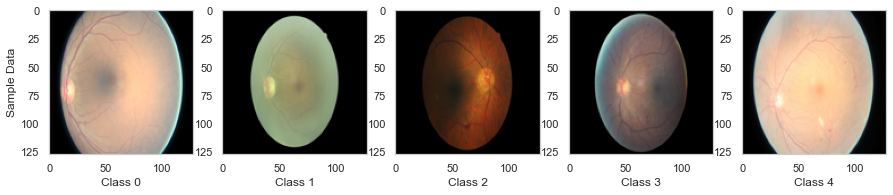

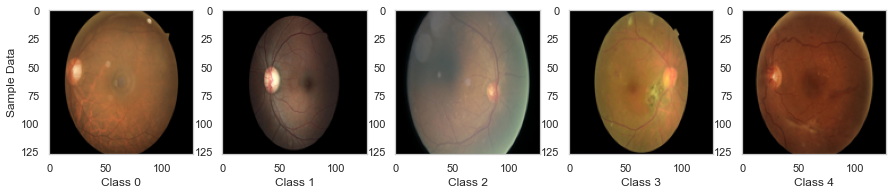

In [ ]:
visualize_imgs(df_train,2,color_scale = None)

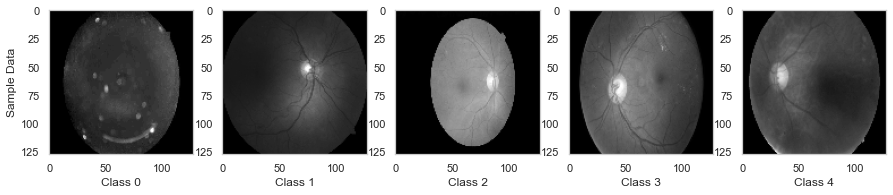

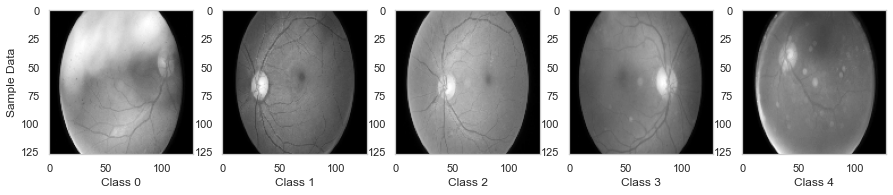

In [ ]:
visualize_imgs(df_train,2,color_scale = 'gray')

##### NOTE : As we can see, as we move towards higher classes, we are able to comprehend larger number of abnormalities in the eye images. Also, the lightning and brightness conditions are non-uniform accross all images. We will try to handle this using image processing techniques. Also, Gray Scale Images are giving better visualization of the eye features as compared to RGB images.

#  <a id = 'section3'> <font color='gray'>  3. Image Processing</font> </a>

### <font color='orange'> 3.1 Gaussian Blur </font>

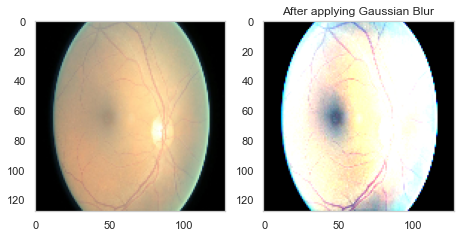

In [ ]:
# This section of code applies gaussian blur on top of image

rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_HEIGHT,IMG_WIDTH))

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

f, axarr = plt.subplots(1,2,figsize = (7.5,7.5))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After applying Gaussian Blur')
plt.show()

##### NOTE : As we can see, after applying Gaussian Blur, We are able to bring out the features/image details much more clearer in the eye.

### <font color='orange'> 3.2 Gaussian Blur with Circular Cropping </font>

In [ ]:
# This Function performs image processing on top of images by performing Gaussian Blur and Circle Crop

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
            
        return img
 
 # This Fucntion performs circular crop around image centre
     
def circle_crop(img, sigmaX):    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

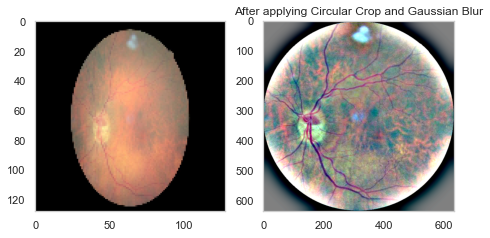

In [ ]:
# This section of code Performs Image Processing on a sample image

rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img_t = circle_crop(img,sigmaX = 30)

f, axarr = plt.subplots(1,2,figsize = (7.5,7.5))
axarr[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(IMG_HEIGHT,IMG_WIDTH)))
axarr[1].imshow(img_t)
plt.title('After applying Circular Crop and Gaussian Blur')
plt.show()

##### NOTE : As we can see above, now the image features and details are very much clearer than what the image was before, we are ready to use this image for modelling as the image details are much more clearer.

In [ ]:
# This Function shows the visual Image photo of 'n x 5' points (5 of each class) 
# and performs image processing (Gaussian Blur, Circular crop) transformation on top of that

def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('Diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.Diagnosis.iloc[i]))

        plt.show()

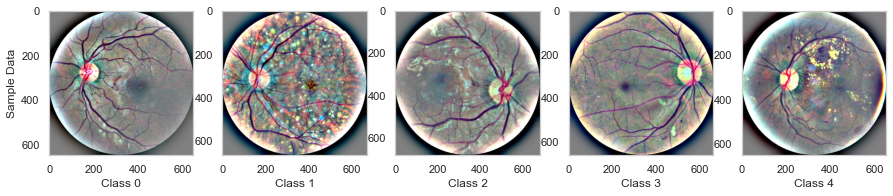

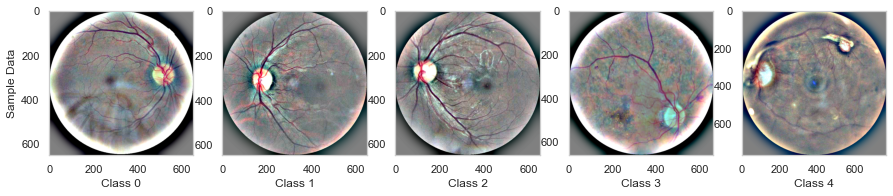

In [ ]:
visualize_img_process(df_train,2,sigmaX = 30)

##### NOTE : Clearly we can understand the importance of performing image processing operations here. We have performed Gaussian Blur to bring out the image details and features much more clearly and explicitly. 

#  <a id = 'section4'> <font color='gray'>  4. TSNE Visualization</font> </a>

In [ ]:
# The code below applies TSNE on Gray Scale Images - The Image is flattened to 2D Gray Image to 1D and then applies TSNE

In [ ]:
# train image data
npix = 128 # resize to npix x npix (for now)
X_train = np.zeros((df_train.shape[0], npix, npix))
for i in tqdm_notebook(range(df_train.shape[0])):
    # load an image
    img = cv2.imread(df_train.file_path.iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    X_train[i, :, :] = cv2.resize(img, (npix, npix)) 
    
print("X_train shape: " + str(np.shape(X_train)))   


X_train shape: (5000, 128, 128)


In [ ]:
# normalize
X = X_train / 255

# reshape
X = X.reshape(X.shape[0], -1)
trainy = df_train['Diagnosis']

In [ ]:
#per_vals = [2,5,10,15,20,30,40,50]
per_vals = [10]

for per in tqdm_notebook(per_vals):
    X_decomposed = TSNE(n_components=2,perplexity = per).fit_transform(X)
    df_tsne = pd.DataFrame(data=X_decomposed, columns=['Dimension_x','Dimension_y'])
    df_tsne['Score'] = trainy.values
    
    sns.FacetGrid(df_tsne, hue='Score', size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
    plt.title('TSNE for perplexity = ' + str(per))
    plt.show()

![WhatsApp%20Image%202021-05-09%20at%2000.50.28.jpeg](attachment:WhatsApp%20Image%202021-05-09%20at%2000.50.28.jpeg)

##### NOTE : As we can see, we are able to seperate Class '0' from other classes (1-4). Seperating between classes 1-4 looks challenging.

#  <a id = 'section5'> <font color='gray'>  5. Data Augmentation</font> </a>

In [ ]:
# This Function generates 'lim' number of Image Augmentations from a random Image in the directory

def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_HEIGHT,IMG_WIDTH))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()
    
    img_arr = img.reshape((1,) + img.shape)
    
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show() 

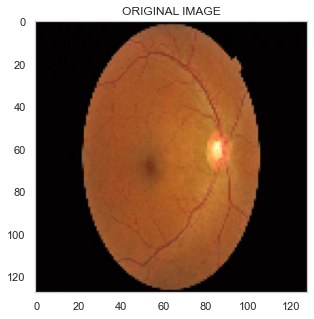

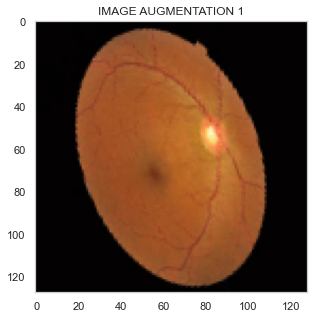

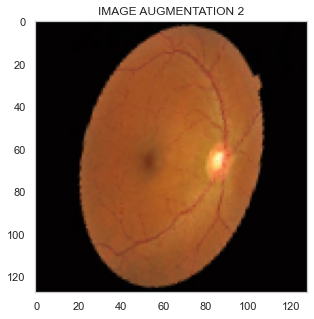

In [ ]:
generate_augmentations(2)

#### NOTE : As we can see above, Image Augmentations are extremely helpful for this datasets to make our Models more Robust and would also have a higher ability to generalize well

#  <a id = 'section6'> <font color='gray'>  6. Train-Validation Split</font> </a>

In [ ]:
df_train_train,df_train_test = train_test_split(df_train,test_size = 0.2)
print(df_train_train.shape,df_train_test.shape)

(4000, 4) (1000, 4)


In [ ]:
# This Function Plots a Bar plot of output Classes Distribution

def plot_classes(df,title):
    df_group = pd.DataFrame(df.groupby('Diagnosis').agg('size').reset_index())
    df_group.columns = ['Diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'Diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution ' + str(title))
    plt.show()

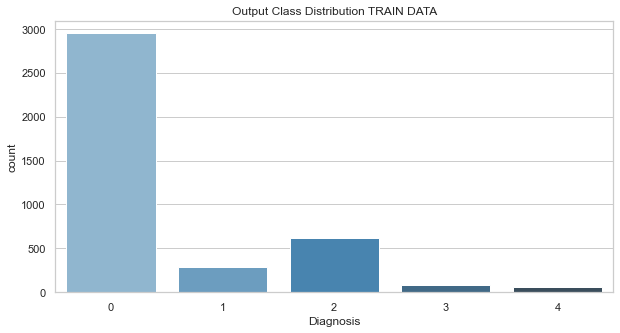

In [ ]:
plot_classes(df_train_train,"TRAIN DATA")

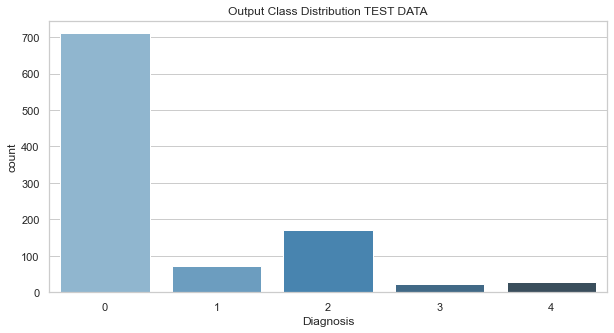

In [ ]:
plot_classes(df_train_test,'TEST DATA')

#  <a id = 'section7'> <font color='gray'>  7. Resize and Save</font> </a>

In [ ]:
IMG_SIZE  = 512

In [ ]:
# This function loads an image from Folder , Resizes and saves in another directory 

def image_resize_save(file):
    input_filepath = os.path.join('/content/gdrive/MyDrive/Project/datasets/train/','{}.jpeg'.format(file))
    output_filepath = os.path.join('/content/gdrive/MyDrive/Project/datasets/train_resized/','{}.jpeg'.format(file))
    img = cv2.imread(input_filepath)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
#image_resize_save(df_train.id_code.iloc[201])

In [ ]:
# This Function uses Multi processing for faster saving of images into folder

def multiprocess_image_downloader(process:int, imgs:list):
  
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(image_resize_save, imgs)
    return results

In [ ]:
# Use 6 cores
multiprocess_image_downloader(6, list(df_train.ImageID.values))

#  <a id = 'section8'> <font color='gray'>  8. Image Pre Processing and save</font> </a>

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
 
            img = np.stack([img1,img2,img3],axis=-1)
  
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess_image(file):
    input_filepath = os.path.join('/content/gdrive/MyDrive/Project/datasets/train_resized/','{}.jpeg'.format(file))
    output_filepath = os.path.join('/content/gdrive/MyDrive/Project/datasets/train_resized_preprocessed/','{}.jpeg'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [ ]:
# This Function uses Multi processing for faster saving of images into folder

def multiprocess_image_processor(process:int, imgs:list):
 
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

# Use 6 cores
multiprocess_image_processor(6, list(df_train.ImageID.values))

#   <a id = 'section9'> <font color='gray'> 9. Custom Image Data generator</font>

In [ ]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 10
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
DEPTH = 3
N_CLASSES = df_train_train['Diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
# This Function creates a custom Image Data generator, 
# Since this is a Multi Output Model, a custom Image data generator is used (which yeild's outputs to next iterator)

def multiple_outputs(generator,dataframe, image_dir, batch_size, height,width, subset):
    gen = generator.flow_from_dataframe(
        dataframe = dataframe,
        x_col = "file_name",
        y_col = "Diagnosis",
        directory = image_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='raw',
        subset=subset)
    
    mlb = MultiLabelBinarizer(classes = range(N_CLASSES))
    
    while True:
        gnext = gen.next()
        yield gnext[0], [np.argmax(gnext[1],axis = -1),gnext[1],mlb.fit_transform([list(range(x+1)) for x in np.argmax(gnext[1],axis = -1)])]

In [ ]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.25,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="C:/Users/Sandeep Saurav/ML Project - DR/datasets/train_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="Diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="C:/Users/Sandeep Saurav/ML Project - DR/datasets/train_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="Diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory = "C:/Users/Sandeep Saurav/ML Project - DR/datasets/train_resized_preprocessed/",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    
    return train_generator,valid_generator,test_generator

In [ ]:
train_generator,valid_generator,test_generator = img_generator(df_train_train,df_train_test)

Found 3000 validated image filenames belonging to 5 classes.
Found 1000 validated image filenames belonging to 5 classes.
Found 1000 validated image filenames.


#   <a id = 'section10'> <font color='gray'> 10. Model Training</font>

In [ ]:
def createModel(input_shape,n_out):
    model = Sequential()
    # first set of CONV => RELU => MAX POOL layers
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(n_out, activation='softmax'))
    return model


In [ ]:
model = createModel(input_shape=(HEIGHT, WIDTH, DEPTH), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 320, 320, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 318, 318, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 159, 159, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 159, 159, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 159, 159, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 157, 157, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 78, 78, 64)        0

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

375 125


In [ ]:
model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

Epoch 1/2
375/375 [==============================] - 1079s 3s/step - loss: 1.0034 - accuracy: 0.7347 - val_loss: 1.0225 - val_accuracy: 0.7240
Epoch 2/2
375/375 [==============================] - 1183s 3s/step - loss: 0.9695 - accuracy: 0.7410 - val_loss: 1.0203 - val_accuracy: 0.7240


In [ ]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

NameError: ignored

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/10
375/375 [==============================] - 2618s 7s/step - loss: 0.3139 - accuracy: 0.7407 - val_loss: 0.3298 - val_accuracy: 0.7240 - lr: 1.0000e-04
Epoch 2/10
375/375 [==============================] - 2076s 6s/step - loss: 0.3137 - accuracy: 0.7410 - val_loss: 0.3159 - val_accuracy: 0.7240 - lr: 1.0000e-04
Epoch 3/10
375/375 [==============================] - 2090s 6s/step - loss: 0.3094 - accuracy: 0.7410 - val_loss: 0.3140 - val_accuracy: 0.7240 - lr: 1.0000e-04
Epoch 4/10
375/375 [==============================] - 2054s 5s/step - loss: 0.3055 - accuracy: 0.7410 - val_loss: 0.3057 - val_accuracy: 0.7240 - lr: 1.0000e-04
Epoch 5/10
375/375 [==============================] - 2077s 6s/step - loss: 0.3067 - accuracy: 0.7410 - val_loss: 0.3125 - val_accuracy: 0.7240 - lr: 1.0000e-04
Epoch 6/10
375/375 [==============================] - 2083s 6s/step - loss: 0.3042 - accuracy: 0.7410 - val_loss: 0.3083 - val_accuracy: 0.7240 - lr: 1.0000e-04
Epoch 7/10
375/375 [==============

In [ ]:
print("Saving model to disk")
sys.stdout.flush()
model.save("C:/Users/Sandeep Saurav/ML Project - DR/models/")

Saving model to disk


<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: C:/Users/Sandeep Saurav/ML Project - DR/models/assets


<IPython.core.display.Javascript object>

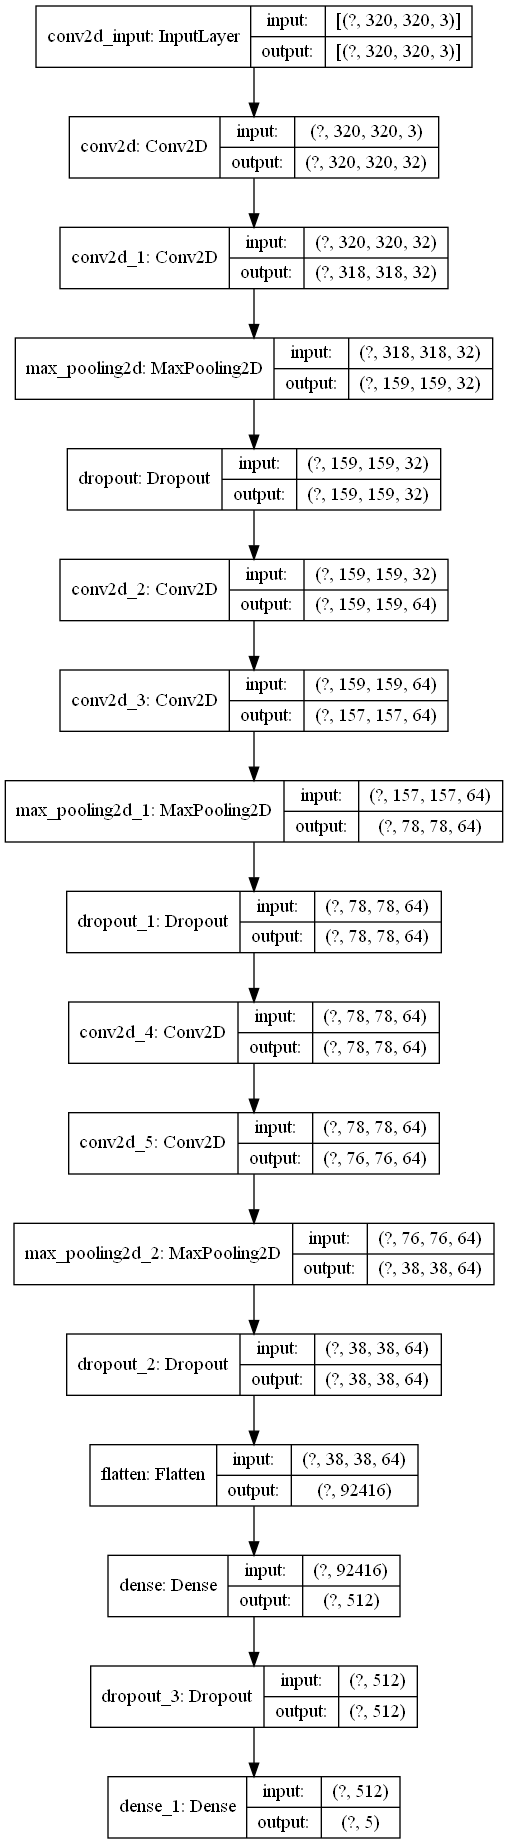

In [ ]:
tf.keras.utils.plot_model(model,to_file="model.png",show_shapes=True,show_layer_names=True,
                          rankdir="TB",expand_nested=False,dpi=96,)

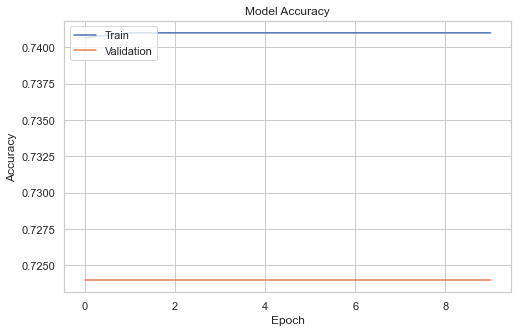

<Figure size 720x360 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()
plt.savefig("C:/Users/Sandeep Saurav/ML Project - DR/plots/Model_Accuracy.png")

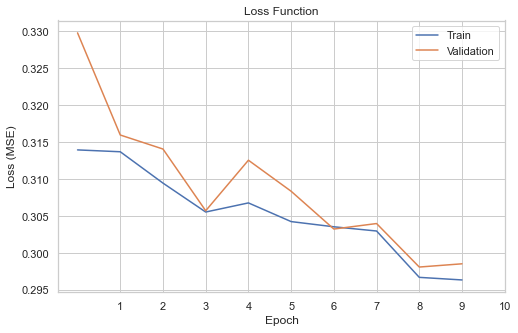

<Figure size 720x360 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_finetunning['loss'])
plt.plot(history_finetunning['val_loss'])
plt.title('Loss Function')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,11))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()
plt.savefig("C:/Users/Sandeep Saurav/ML Project - DR/plots/Loss_Function.png")

### <font color='orange'> 10.1 Generate Train Predictions on complete Train Data </font>

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = "C:/Users/Sandeep Saurav/ML Project - DR/datasets/train_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 4000 validated image filenames.
Instructions for updating:
Please use Model.predict, which supports generators.
4000/4000 [==============================] - 872s 218ms/step


In [ ]:
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['Diagnosis'].astype('int'),train_preds))

Train Accuracy score : 0.737


#   <a id = 'section11'> <font color='gray'> 11. Evaluate Model on Test Data </font>

In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

1000/1000 [==============================] - 238s 238ms/step


In [ ]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()
    plt.savefig("/content/gdrive/MyDrive/Project/plots/Conf_matrix.png")

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_train_test['Diagnosis'].astype(int)),test_labels,labels)

![Conf_matrix.png](attachment:Conf_matrix.png)

In [ ]:
cnf_matrix = confusion_matrix(df_train_test['Diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(8, 5.5))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()
plt.savefig("/content/gdrive/MyDrive/Project/plots/Heat_map.png")

![Heat_map.png](attachment:Heat_map.png)

In [ ]:
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['Diagnosis'].astype('int'),test_labels))

Test Accuracy score : 0.710
